In [ ]:
from ceruleanml import data
from ceruleanml import eval
from ceruleanml import load_negative_tiles
from icevision.parsers import COCOMaskParser
from icevision.data import SingleSplitSplitter
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.vision.augment import aug_transforms
from fastai.vision.learner import unet_learner
from fastai.data.transforms import RandomSplitter, Normalize
from fastai.metrics import Dice
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from torchvision.models import resnet18, resnet34, resnet50
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.tensorboard import TensorBoardCallback
from datetime import datetime
from pathlib import Path
import os, glob, random
from statistics import mean
from icevision.visualize import show_data
import torch

### Parsing COCO Dataset with Icevision

In [2]:
data_path = "/root/"
mount_path = "/root/data"

#### Importing functions for returning an image sample and a semantic segmentation label for each sample

In [ ]:
def get_image_by_record_id(record_id):
    return get_image_path(positive_train_records, record_id)

def get_mask_by_record_id(record_id):
    return record_to_mask(positive_valid_records, record_id)

#### Parsing (positive) examples

In [3]:
class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))
parser = COCOMaskParser(annotations_filepath=f"{mount_path}/tile-cerulean-v2-partial-with-context/instances_Tiled Cerulean Dataset V2.json", img_dir=f"{mount_path}/tile-cerulean-v2-partial-with-context/tiled_images")
positive_train_records, positive_valid_records = parser.parse(autofix=False)

  0%|          | 0/3883 [00:00<?, ?it/s]

In [ ]:
positive_train_records[0]

In [4]:
record_ids = record_collection_to_record_ids(positive_train_records)

#### Get metrics on area for each record

In [5]:
len(positive_train_records)

2414

In [6]:
record_area_label_list = []

In [9]:
ClassMap = {'background': 0, 'infra_slick': 1, 'natural_seep': 2, 'coincident_vessel': 3, 'recent_vessel': 4, 'old_vessel': 5, 'ambiguous': 6}

In [10]:
def get_area_by_record_id(positive_train_record):
    positive_train_record = positive_train_record.as_dict()
    for i in range(len(positive_train_record['detection']['areas'])):
        record_area_label = (positive_train_record['common']['record_id'], positive_train_record['detection']['labels'][i], positive_train_record['detection']['areas'][i])
        #print(record_area_label)
        record_area_label_list.append(record_area_label)
    return

In [11]:
for i in range(len(positive_train_records)):
    get_area_by_record_id(positive_train_records[i])

In [12]:
record_area_label_list_min = min(record_area_label_list,key=lambda item:item[2])
record_area_label_list_max = max(record_area_label_list,key=lambda item:item[2])

In [ ]:
record_area_label_list_min, record_area_label_list_max

#### Specify by (min, max, mean) class

In [14]:
record_area_list_infra_slick = [i for i in record_area_label_list if i[1] == 'infra_slick']
record_area_list_natural_seep = [i for i in record_area_label_list if i[1] == 'natural_seep']
record_area_list_coincident_vessel = [i for i in record_area_label_list if i[1] == 'coincident_vessel']
record_area_list_recent_vessel = [i for i in record_area_label_list if i[1] == 'recent_vessel']
record_area_list_old_vessel = [i for i in record_area_label_list if i[1] == 'old_vessel']
record_area_list_ambiguous = [i for i in record_area_label_list if i[1] == 'ambiguous']

In [15]:
record_area_list_infra_slick_min = min(record_area_list_infra_slick,key=lambda item:item[2])
record_area_list_infra_slick_max = max(record_area_list_infra_slick,key=lambda item:item[2])
record_area_list_natural_seep_min = min(record_area_list_natural_seep,key=lambda item:item[2])
record_area_list_natural_seep_max = max(record_area_list_natural_seep,key=lambda item:item[2])
record_area_list_coincident_vessel_min = min(record_area_list_coincident_vessel,key=lambda item:item[2])
record_area_list_coincident_vessel_max = max(record_area_list_coincident_vessel,key=lambda item:item[2])
record_area_list_recent_vessel_min = min(record_area_list_recent_vessel,key=lambda item:item[2])
record_area_list_recent_vessel_max = max(record_area_list_recent_vessel,key=lambda item:item[2])
record_area_list_old_vessel_min = min(record_area_list_old_vessel,key=lambda item:item[2])
record_area_list_old_vessel_max = max(record_area_list_old_vessel,key=lambda item:item[2])
record_area_list_ambiguous_min = min(record_area_list_ambiguous,key=lambda item:item[2])
record_area_list_ambiguous_max = max(record_area_list_ambiguous,key=lambda item:item[2])

In [16]:
record_area_list_infra_slick_mean = mean([item[2] for item in record_area_list_infra_slick if item[2] != 0])
record_area_list_natural_seep_mean = mean([item[2] for item in record_area_list_natural_seep if item[2] != 0])
record_area_list_coincident_vessel_mean = mean([item[2] for item in record_area_list_coincident_vessel if item[2] != 0])
record_area_list_recent_vessel_mean = mean([item[2] for item in record_area_list_recent_vessel if item[2] != 0])
record_area_list_old_vessel_mean = mean([item[2] for item in record_area_list_old_vessel if item[2] != 0])
record_area_list_ambiguous_mean = mean([item[2] for item in record_area_list_ambiguous if item[2] != 0])

In [ ]:
record_area_list_infra_slick_min, record_area_list_infra_slick_max, record_area_list_infra_slick_mean

In [ ]:
record_area_list_natural_seep_min, record_area_list_natural_seep_max, record_area_list_natural_seep_mean

In [ ]:
record_area_list_coincident_vessel_min, record_area_list_coincident_vessel_max, record_area_list_coincident_vessel_mean

In [ ]:
record_area_list_recent_vessel_min, record_area_list_recent_vessel_max, record_area_list_recent_vessel_mean

In [ ]:
record_area_list_old_vessel_min, record_area_list_old_vessel_max, record_area_list_old_vessel_mean

In [ ]:
record_area_list_ambiguous_min, record_area_list_ambiguous_max, record_area_list_ambiguous_mean

#### Get list of flagged records

In [ ]:
area_thresh = 10

In [23]:
low_area_list = []

In [24]:
def flag_record_by_area(positive_train_record):
    positive_train_record = positive_train_record.as_dict()
    for i in range(len(positive_train_record['detection']['areas'])):
        if positive_train_record['detection']['areas'][i] < area_thresh:
            #print(positive_train_record)
            low_area_list.append(positive_train_record)
    return

In [25]:
for i in range(len(positive_train_records)):
    flag_record_by_area(positive_train_records[i])

In [ ]:
len(low_area_list)

#### Nullify detection params for flagged annotations

In [27]:
def ignore_record_by_area(positive_train_record):
    positive_train_record = positive_train_record.as_dict()
    for i in range(len(positive_train_record['detection']['areas'])):
        if positive_train_record['detection']['areas'][i] < area_thresh:
            positive_train_record['detection']['areas'][i] = None
            positive_train_record['detection']['labels'][i] = None
            positive_train_record['detection']['label_ids'][i] = None
            positive_train_record['detection']['bboxes'][i] = None
            positive_train_record['detection']['masks'][i] = None
            positive_train_record['detection']['iscrowds'][i] = None
            print(positive_train_record)
    return

In [ ]:
for i in range(len(positive_train_records)):
    ignore_record_by_area(positive_train_records[i])
    

#### Parse negative tiles

In [29]:
images_available = glob.glob(f"{mount_path}/tile-cerulean-v2-partial-with-context/tiled_images/*")

In [30]:
len(images_available)

58332

In [31]:
record_ids = record_collection_to_record_ids(positive_train_records)

Note: The count argument in the line below allows you to control how many negative tiles are desired.

In [32]:
negative_train_records, negative_valid_records = load_negative_tiles.parse_negative_tiles(data_dir=f"{mount_path}/tile-cerulean-v2-partial-with-context/tiled_images", record_ids=record_ids, positive_train_records=positive_train_records, count=100)


  0%|          | 0/100 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
negative_train_records[0]

BaseRecord

common: 
	- Image size ImgSize(width=512, height=512)
	- Filepath: /root/data/tile-cerulean-v2-partial-with-context/tiled_images/S1B_IW_GRDH_1SDV_20210805T043953_20210805T044018_028106_035A5F_D096_vv-image_local_tile_79.tif
	- Img: None
	- Record ID: S1B_IW_GRDH_1SDV_20210805T043953_20210805T044018_028106_035A5F_D096_vv-image_local_tile_79
detection: 
	- BBoxes: []
	- Class Map: None
	- Labels: []
	- masks: []
	- mask_array: None

In [ ]:
len(negative_train_records)

#### Combine the positive and negative parsed examples

In [35]:
combined_train_records = positive_train_records + negative_train_records
combined_valid_records = positive_valid_records + negative_valid_records

In [36]:
record_ids = record_collection_to_record_ids(combined_train_records)

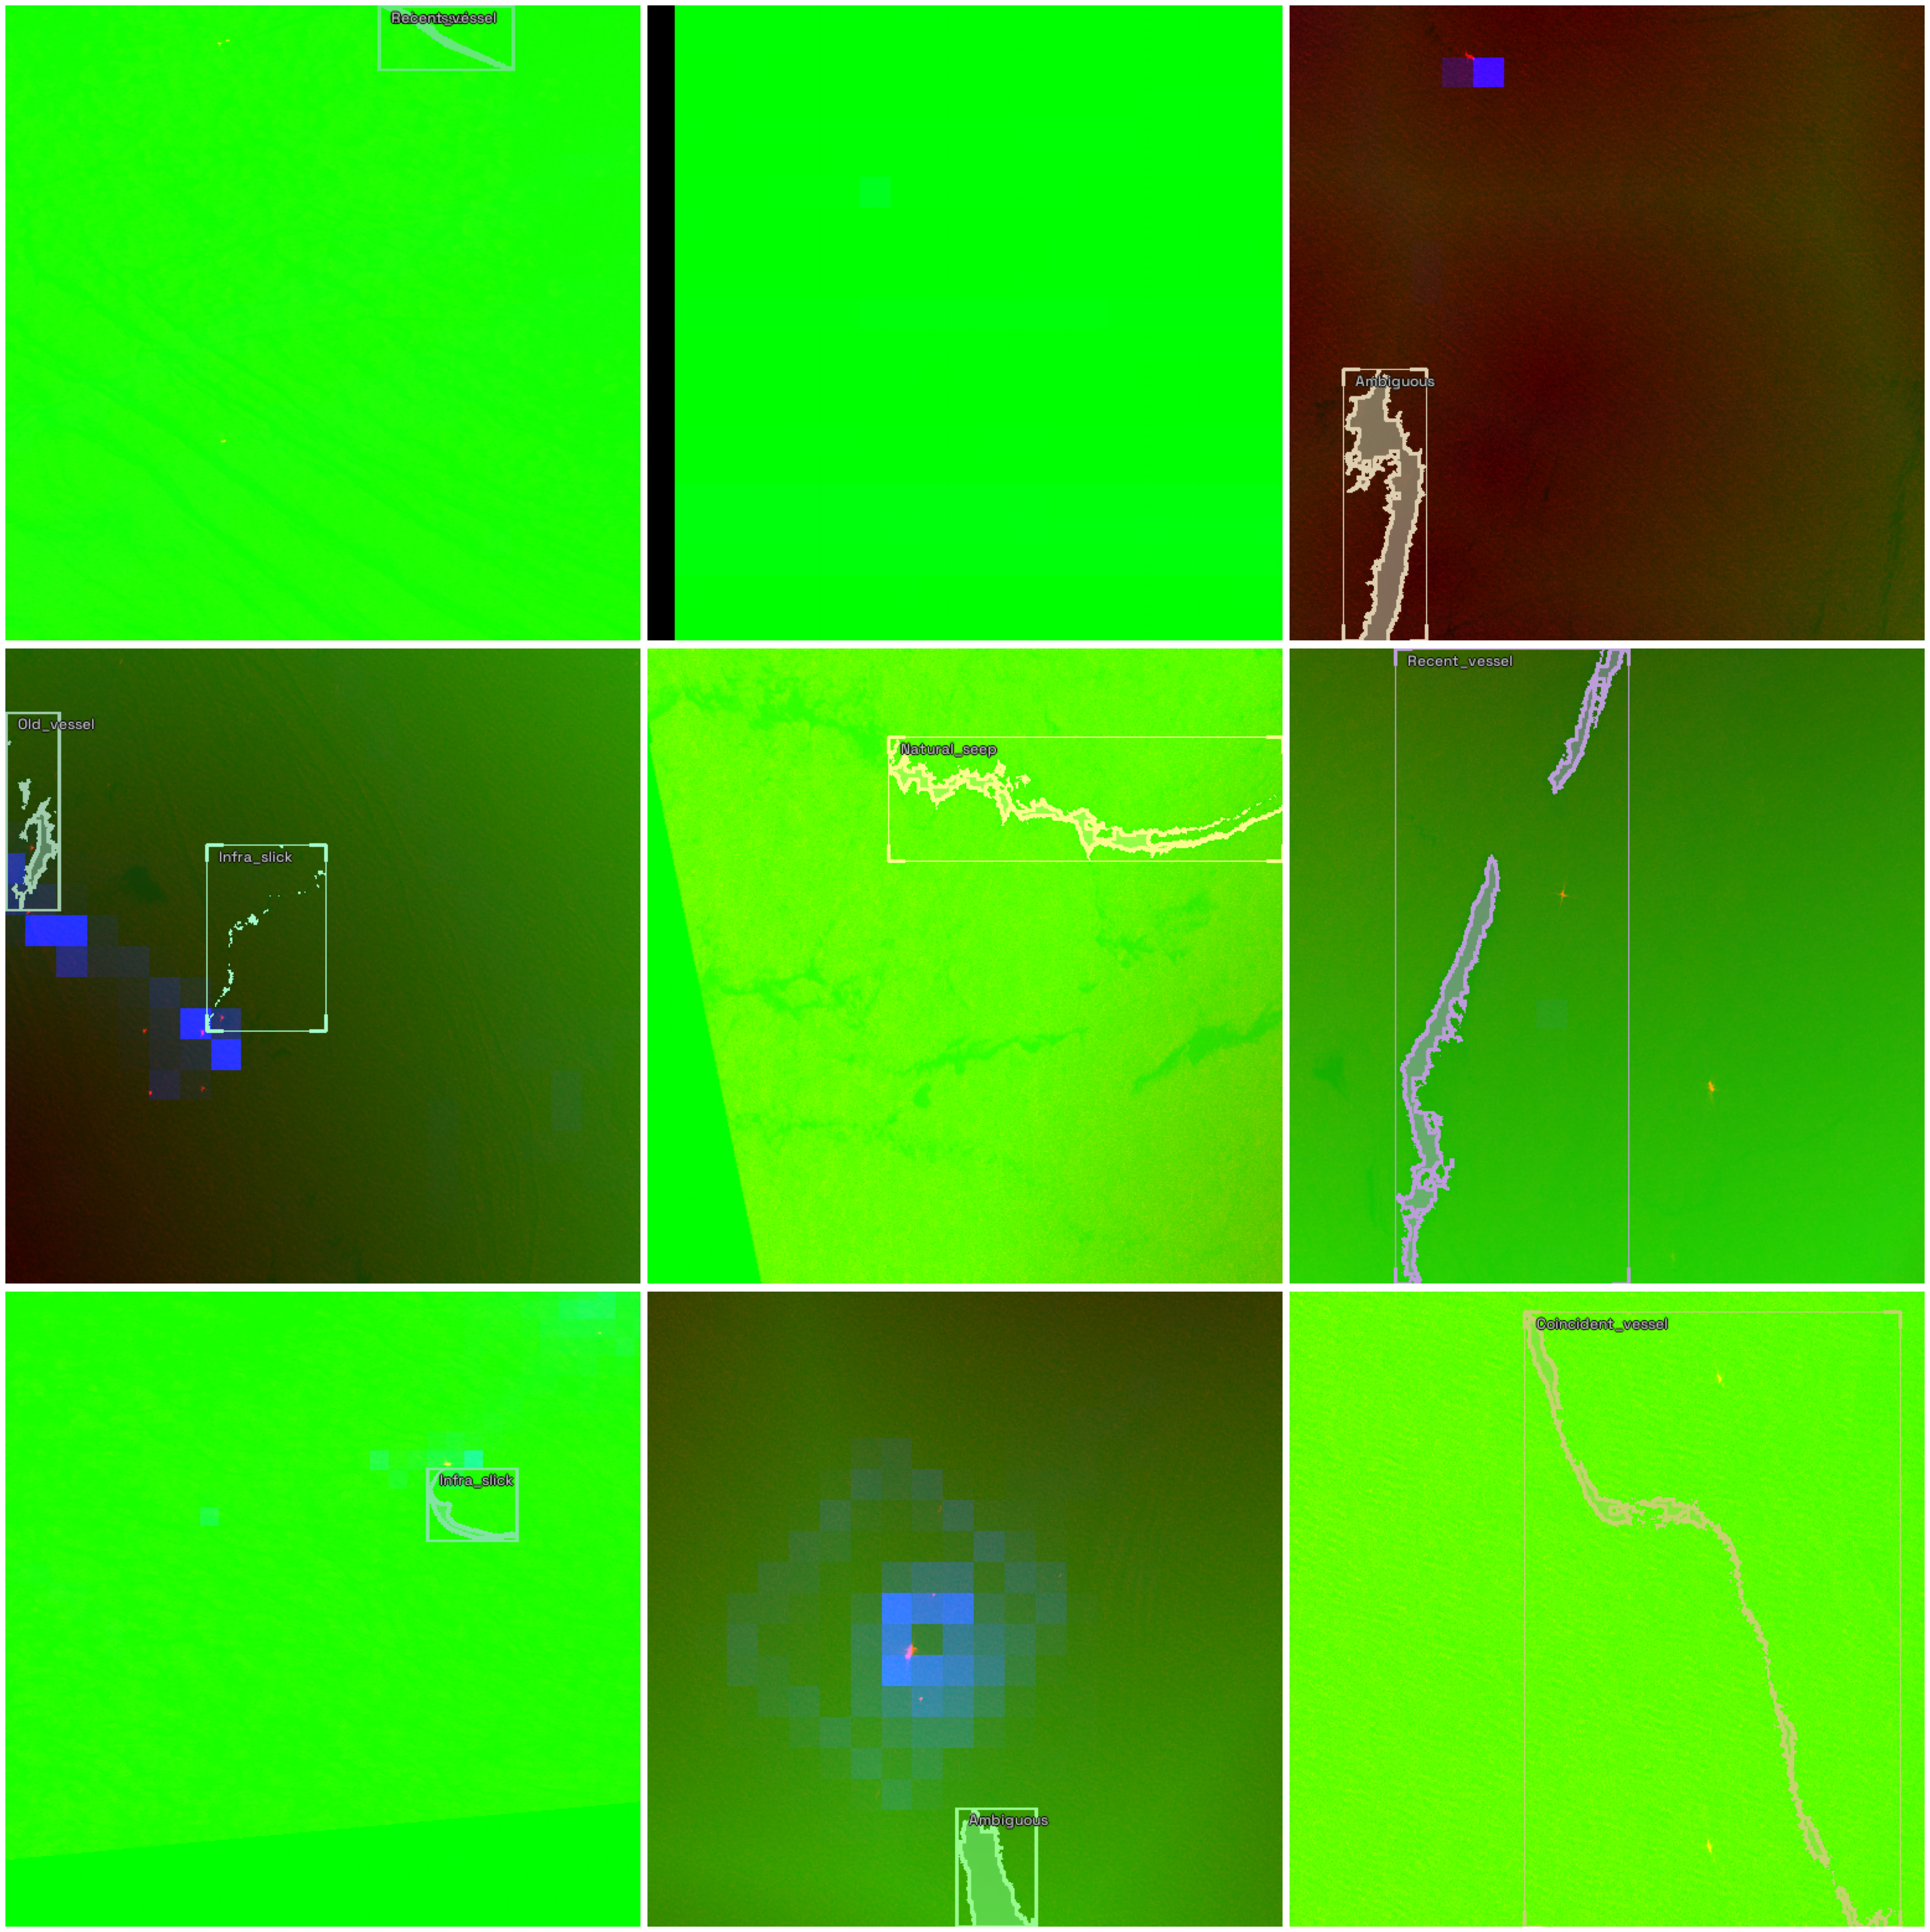

In [38]:
show_data.show_records(random.choices(combined_train_records, k=9), ncols=3)

### Constructing a FastAI DataBlock that uses parsed COCO Dataset from icevision parser and applies transformations

In [15]:
mean = [60.73,       190.3,      4.3598]
std = [16.099,      17.846,       9.603]

In [7]:
batch_transfms = [aug_transforms(),  Normalize.from_stats(mean,std)]

In [8]:
#size = 64  # Progressive resizing could happen here
augs = aug_transforms(flip_vert=True, max_warp=0.1) #, size=size)
coco_seg_dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=class_ints)),
    get_x=get_image_by_record_id,
    splitter=RandomSplitter(),
    get_y=get_mask_by_record_id,
    batch_tfms=[Normalize.from_stats(mean,std)],
    n_inp=1,
)

dls = coco_seg_dblock.dataloaders(source=record_ids, batch_size=1)

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


### Fastai2 Trainer

In [9]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
experiment_dir =  Path(f'{mount_path}/experiments/cv2/'+timestampStr+'_fastai_unet/')
experiment_dir.mkdir(exist_ok=True)

In [10]:
arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

In [11]:
learner = unet_learner(dls, archs[arch], metrics=[Dice()], model_dir=experiment_dir, n_out = 7, cbs=[MixedPrecision]) # cbs=[MixedPrecision]

#lr = learner.lr_find()

cbs = [TensorBoardCallback(projector=False, trace_model=False)]

learner.fine_tune(1, 2e-4, cbs=cbs)#, cbs=SaveModelCallback(monitor='dice'))w

In [12]:
validation = learner.validate()

In [13]:
size=512
savename = f'test_1batch_{arch}_{size}_{round(validation[1],3)}.pt'

In [14]:
from ceruleanml.inference import save_fastai_model_state_dict_and_tracing, load_tracing_model, test_tracing_model_one_batch, logits_to_classes

In [15]:
state_dict_pth, tracing_model_gpu_pth, tracing_model_cpu_pth  = save_fastai_model_state_dict_and_tracing(learner, dls, savename, experiment_dir)

/root/data/experiments/cv2/24_May_2022_01_49_56_fastai_unet/tracing_gpu_test_1batch_18_512_0.082.pt
/root/data/experiments/cv2/24_May_2022_01_49_56_fastai_unet/tracing_cpu_test_1batch_18_512_0.082.pt
/root/data/experiments/cv2/24_May_2022_01_49_56_fastai_unet/state_dict_test_1batch_18_512_0.082.pt


In [19]:
import torch
experiment_dir = '/root/data/experiments/cv2/24_May_2022_01_49_56_fastai_unet/'
savename = "tracing_cpu_test_1batch_18_512_0.082.pt"
tracing_model = load_tracing_model(os.path.join(experiment_dir, savename))
out_batch_logits = test_tracing_model_one_batch(dls.to('cpu'), tracing_model)

In [20]:
conf, classes = logits_to_classes(out_batch_logits)

In [21]:
classes.shape

torch.Size([1, 512, 512])

In [22]:
conf.shape

torch.Size([1, 512, 512])

In [ ]:
learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)

Default path for tensorboard logs is `./runs/`

In [ ]:
f'{mount_path}/experiments/cv2/'

In [ ]:
!ls '/root/data/experiments/cv2/20_May_2022_19_29_39_fastai_unet'

In [ ]:
!ls './runs/'

Copy logs to appropriate exeriments folder in the mounted GCS volume.

In [ ]:
!cp -R './runs/' {modelpath}'/tensorboard/'

Now, run the following from anywhere with gcs authenticated:

In [ ]:
!tensorboard --logdir="./runs"


# Model Inference and Result Evaluation

In [ ]:
val_record_ids = record_collection_to_record_ids(valid_records)
pred_arrs = []
val_arrs = []
with learn.no_logging():
    for v, i in zip(range(len(val_record_ids[0:10])), val_record_ids[0:10]):
        v = valid_records[v].as_dict()
        v_masks = v['detection']['masks'][0].to_mask(v['common']['height'],v['common']['width']).data
        p = get_image_path(valid_records,i)
        arr = skio.imread(p)
        pred_arr = learn.predict(arr)
        pred_arr = pred_arr[0].cpu().detach().numpy()
        pred_arrs.append(pred_arr)
        val_arrs.append(v_masks)

In [ ]:
cm, f1 = eval.cm_f1(val_arrs, pred_arrs, 6, mount_path)

In [ ]:
learner = torch.load("/root/data/experiments/cv2/10_May_2022_18_02_59_fastai_unet/18_64_0.493.pkl")

In [ ]:
learner.predict??

In [ ]:
import skimage.io as skio
val_record_ids = record_collection_to_record_ids(valid_records)
pred_arrs = []
with learner.no_logging():
    for i in val_record_ids:
        p = get_image_path(valid_records,i)
        arr = skio.imread(p)
        pred_arr = learner.predict(arr)
        pred_arrs.append(pred_arr)

In [ ]:
# this results in vm dying, not just kernel crash
# coco_seg_dblock = DataBlock(
#     blocks=(ImageBlock, MaskBlock(codes=class_ints)),
#     get_x=get_image_by_record_id,
#     get_y=get_mask_by_record_id,
#     n_inp=1,
# )

# dls = coco_seg_dblock.dataloaders(source=record_ids, batch_size=5)


In [ ]:
result = learner.get_preds(dl=dls[0])

In [ ]:
learner.get_preds??

In [ ]:
len(pred_arrs)

In [ ]:
target_label,prediction_arr, activations = pred_arrs[0]

In [ ]:
skio.imshow(target_label.cpu().detach().numpy())

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[0])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy())

In [ ]:
array([      60.73,       190.3,      4.3598]) # means
array([     16.099,      17.846,       9.603]) # stats